# Explainability in Deep Learning models (Vehicle Image Classification)

# Importing Required Libraries

In [1]:
# import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

import torch
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
from torch.utils.data import DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
from torchvision import datasets

from sklearn.metrics import confusion_matrix, classification_report

import os
import cv2
import warnings
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Set TensorFlow to not show unnecessary logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Loading Dataset from File

In [ ]:
# Loading data from the file path
train_dataset_path = '/content/drive/MyDrive/Data/train'
val_dataset_path = '/content/drive/MyDrive/Data/pred'
test_dataset_path = '/content/drive/MyDrive/Data/test'

### Performing some data Augumentation on the training, validation and test datasets




In [ ]:
#Data Augumentation


# Defining image dimensions
width = 224
height = 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,  # Adding Horizontal flip for symmetry
    vertical_flip=False,   # Excluding Vertical Flip
    rotation_range=0,      # No rotation for now . Exploring different degrees
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dataset_path,
    target_size=(width, height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

# Printing the class indices to ensure classes are loaded correctly
print(train_generator.class_indices)

Found 491 images belonging to 2 classes.
{'Has_Contact': 0, 'No_Contact': 1}


In [ ]:
val_datagen = ImageDataGenerator(
    rescale=1.0/255,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,  # Horizontal flip for symmetry
    vertical_flip=False,   # Vertical flip might not be appropriate for medical images
    rotation_range=0,      # No rotation for now (adjust if needed)
    fill_mode='nearest'
    )
val_generator = val_datagen.flow_from_directory(val_dataset_path,
                                                   target_size=(width, height),
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=True)

# Printing the class indices to ensure classes are loaded correctly
print(val_generator.class_indices)

Found 67 images belonging to 2 classes.
{'Has_Contact': 0, 'No_Contact': 1}


In [ ]:
#Data Augumentation

# Defining image dimensions
width = 224
height = 224
batch_size = 32

test_datagen = ImageDataGenerator( rescale=1.0/255,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,  # Horizontal flip for symmetry
    vertical_flip=False,   # Vertical flip might not be appropriate for medical images
    rotation_range=0,      # No rotation for now (adjust if needed)
    fill_mode='nearest'
    )

test_generator = test_datagen.flow_from_directory(test_dataset_path,
                                                   target_size=(width, height),
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=True)

# Printing the class indices to ensure classes are loaded correctly
print(test_generator.class_indices)

Found 54 images belonging to 2 classes.
{'Has_Contact': 0, 'No_Contact': 1}


In [ ]:
from collections import Counter

def count_images_per_class(generator):
    # Collect labels from generator
    labels = []
    # Iterate over batches
    for _, batch_labels in generator:
        labels.extend(batch_labels)
        # Stop if we've gone through the entire dataset
        if len(labels) >= generator.samples:
            break

    # Since the labels are binary, they will either be 0 or 1 (no need for argmax)
    labels = [int(label) for label in labels]

    # Count the occurrences of each class (0 and 1)
    class_counts = Counter(labels)

    # Convert to dictionary for easier access
    class_counts_dict = dict(class_counts)

    return class_counts_dict

# Example usage with the train_generator and test_generator
train_class_counts = count_images_per_class(train_generator)
val_class_counts = count_images_per_class(val_generator)

# Get class names from the generator's class_indices attribute (binary classification should only have two classes)
class_names = list(train_generator.class_indices.keys())

# Map class index to names for both train and test datasets
train_class_counts_named = {class_names[i]: count for i, count in train_class_counts.items()}
val_class_counts_named = {class_names[i]: count for i, count in val_class_counts.items()}

# Print the class distribution for training and validation datasets
print("Number of images per class in training set:", train_class_counts_named)
print("Number of images per class in Validation set:", val_class_counts_named)

Number of images per class in training set: {'No_Contact': 225, 'Has_Contact': 266}
Number of images per class in Validation set: {'No_Contact': 41, 'Has_Contact': 26}


### Viewing sample loaded images from the training dataset

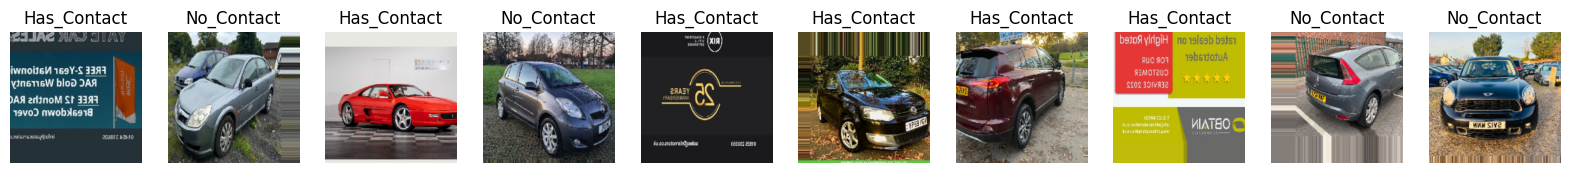

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define function to display images
def imshow(images, labels, class_indices):
    """Display images with labels."""
    fig, axes = plt.subplots(1, len(images), figsize=(20, 20))
    for img, lbl, ax in zip(images, labels, axes):
        ax.imshow(img)
        ax.set_title(class_indices[lbl])
        ax.axis('off')
    plt.show()

# Get a batch of training data
images, labels = next(train_generator)
images = images[:10]  # Get first 10 images
labels = labels[:10]  # Use corresponding labels directly if they are class indices

# Map class indices to class names
class_indices = {v: k for k, v in train_generator.class_indices.items()}

# Display images
imshow(images, labels, class_indices)


### Implementing Sequential CNN Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2

def create_model():
    model = Sequential([
        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', input_shape=(224, 224, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=128, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=256, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Flatten(),

        Dense(units=256, activation='relu'),
        Dropout(0.5),

        # Final layer for binary classification
        Dense(units=1, activation='sigmoid')
    ])

    return model


### Training Sequential CNN Model





In [ ]:
from tqdm.keras import TqdmCallback
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import binary_crossentropy

# Define a custom TQDM progress bar callback
class TQDMProgressBar(TqdmCallback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.epoch_bar = tqdm(total=self.epochs, desc='Epochs', position=0)

    def on_epoch_begin(self, epoch, logs=None):
        self.steps = self.params['steps']
        self.batch_bar = tqdm(total=self.steps, desc=f'Epoch {epoch + 1}/{self.epochs}', position=1, leave=False)

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_bar.update(1)
        self.batch_bar.close()

    def on_batch_end(self, batch, logs=None):
        self.batch_bar.update(1)

    def on_train_end(self, logs=None):
        self.epoch_bar.close()

tqdm_progress_bar = TQDMProgressBar()

# Create model (assuming 'create_model' function is defined elsewhere)
cnn_model = create_model()

# Compile the model
cnn_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=binary_crossentropy,
    metrics=['accuracy']
)

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
Model_Train = cnn_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    verbose=0,  # Disable built-in verbose to use custom tqdm callback
    callbacks=[reduce_lr, early_stopping, tqdm_progress_bar]
)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 2/10:   0%|          | 0/16 [00:00<?, ?it/s]
                                                  
Epoch 3/10:   0%|          | 0/16 [00:00<?, ?it/s]
                                                  
Epoch 4/10:   0%|          | 0/16 [00:00<?, ?it/s]
                                                  
Epoch 5/10:   0%|          | 0/16 [00:00<?, ?it/s]
                                                  
Epochs:   0%|          | 0/10 [07:49<?, ?it/s]


In [ ]:
# printing model summary
print(cnn_model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 222, 222, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 111, 111, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 109, 109, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 54, 54, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 52, 52, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 26, 26, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       9,437,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 29,482,181 (112.47 MB)

 Trainable params: 9,827,073 (37.49 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 19,654,148 (74.97 MB)

None


In [ ]:
#printing model results
train_accuracy = Model_Train.history['accuracy']
val_accuracy = Model_Train.history['val_accuracy']

train_loss = Model_Train.history['loss']
val_loss = Model_Train.history['val_loss']

# Print training and validation metrics in a formatted manner
print("Epoch | Train Accuracy | Val Accuracy | Train Loss | Val Loss")
print("-" * 50)  # Print a line separator

for epoch in range(len(train_accuracy)):
    print(f"{epoch + 1:>5} | {train_accuracy[epoch]:<14.4f} | {val_accuracy[epoch]:<12.4f} | {train_loss[epoch]:<10.4f} | {val_loss[epoch]:<8.4f}")

Epoch | Train Accuracy | Val Accuracy | Train Loss | Val Loss
--------------------------------------------------
    1 | 0.5490         | 0.2321       | 1.1032     | 0.7847  
    2 | 0.6102         | 0.2143       | 1.0258     | 0.8244  
    3 | 0.6878         | 0.2143       | 0.8557     | 0.9911  
    4 | 0.6959         | 0.2143       | 0.7840     | 1.0225  
    5 | 0.6592         | 0.2143       | 0.8396     | 2.2740  
    6 | 0.6776         | 0.2143       | 0.7815     | 1.8381  


### Plotting Train Loss and Accuracy Curves

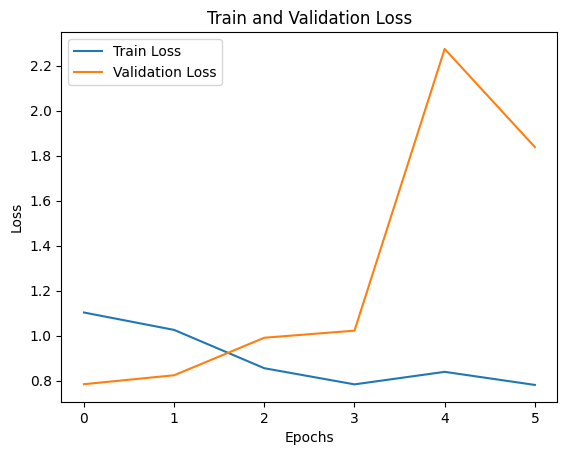

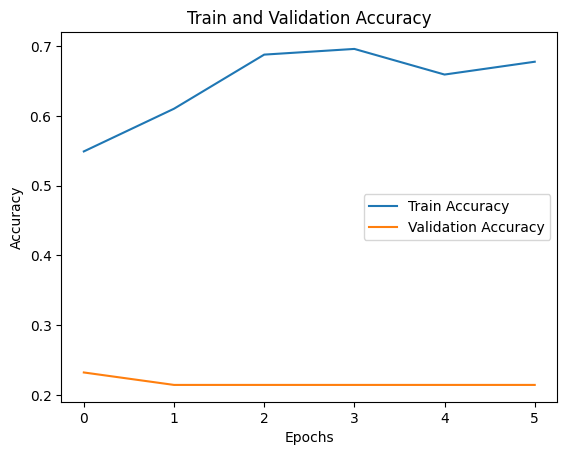

In [ ]:
plt.figure()
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy , label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

### Implementing Pre-Trained VGG16 Model

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tqdm.keras import TqdmCallback

# Define the VGG16 model for binary classification
def create_vgg16_model(input_shape):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Binary classification: 1 output with sigmoid activation
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    return model

# Define input shape (224x224x3)
width, height = 224, 224
input_shape = (width, height, 3)

# Create the VGG16 model for binary classification
vgg16_model = create_vgg16_model(input_shape)

# Compile the model for binary classification
vgg16_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=BinaryCrossentropy(),  # Use binary cross-entropy for binary classification
    metrics=['accuracy']
)

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
tqdm_progress_bar = TqdmCallback()

# Train the model
Model_Train = vgg16_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    verbose=0,  # Using custom tqdm callback for progress bar
    callbacks=[reduce_lr, early_stopping, tqdm_progress_bar]
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [ ]:
# printing the model summary
print(vgg16_model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 63,413,189 (241.90 MB)

 Trainable params: 21,137,729 (80.63 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 42,275,460 (161.27 MB)

None


In [ ]:
train_accuracy = Model_Train.history['accuracy']
val_accuracy = Model_Train.history['val_accuracy']

train_loss = Model_Train.history['loss']
val_loss = Model_Train.history['val_loss']

# Print training and validation metrics in a formatted manner
print("Epoch | Train Accuracy | Val Accuracy | Train Loss | Val Loss")
print("-" * 50)  # Print a line separator

for epoch in range(len(train_accuracy)):
    print(f"{epoch + 1:>5} | {train_accuracy[epoch]:<14.4f} | {val_accuracy[epoch]:<12.4f} | {train_loss[epoch]:<10.4f} | {val_loss[epoch]:<8.4f}")

Epoch | Train Accuracy | Val Accuracy | Train Loss | Val Loss
--------------------------------------------------
    1 | 0.4990         | 0.3881       | 0.7550     | 0.8108  
    2 | 0.7251         | 0.7015       | 0.5273     | 0.5873  
    3 | 0.7617         | 0.7761       | 0.5081     | 0.5572  
    4 | 0.7902         | 0.7910       | 0.4633     | 0.4968  
    5 | 0.8554         | 0.8657       | 0.3778     | 0.4250  
    6 | 0.8432         | 0.8507       | 0.3502     | 0.3870  
    7 | 0.8574         | 0.7612       | 0.3299     | 0.5500  
    8 | 0.8473         | 0.7164       | 0.3674     | 0.5750  
    9 | 0.8595         | 0.8358       | 0.3375     | 0.4222  
   10 | 0.8717         | 0.8507       | 0.3068     | 0.4111  


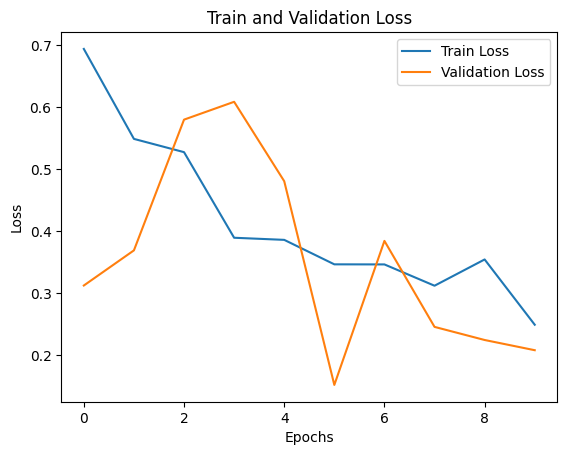

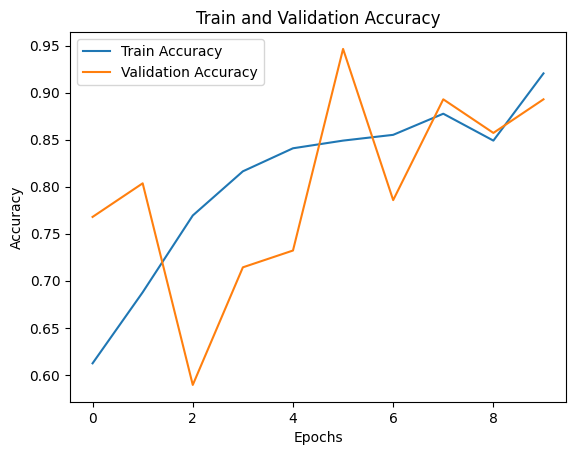

In [ ]:
plt.figure()
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss , label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

### Implementing Pre-Trained RestNet50 Model

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tqdm.keras import TqdmCallback

# Define the ResNet50 model for binary classification
def create_resnet50_model(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Binary classification: 1 output with sigmoid activation
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    return model

# Define input shape (e.g., 224x224x3)
width, height = 224, 224
input_shape = (width, height, 3)

# Create ResNet50 model for binary classification
resnet50_model = create_resnet50_model(input_shape)

# Compile the model for binary classification
resnet50_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=BinaryCrossentropy(),  # Use binary cross-entropy for binary classification
    metrics=['accuracy']
)

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
tqdm_progress_bar = TqdmCallback()

# Train the model
Model_Train = resnet50_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    verbose=0,  # Use custom tqdm callback for progress bar
    callbacks=[reduce_lr, early_stopping, tqdm_progress_bar]
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]


Epoch 7: ReduceLROnPlateau reducing learning rate to 3.1622775802825264e-05.


In [ ]:
print(resnet50_model.summary())

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 147,728,773 (563.54 MB)

 Trainable params: 49,225,217 (187.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 98,450,436 (375.56 MB)

None


In [ ]:
train_accuracy = Model_Train.history['accuracy']
val_accuracy = Model_Train.history['val_accuracy']

train_loss = Model_Train.history['loss']
val_loss = Model_Train.history['val_loss']

# Print training and validation metrics in a formatted manner
print("Epoch | Train Accuracy | Val Accuracy | Train Loss | Val Loss")
print("-" * 50)  # Print a line separator

for epoch in range(len(train_accuracy)):
    print(f"{epoch + 1:>5} | {train_accuracy[epoch]:<14.4f} | {val_accuracy[epoch]:<12.4f} | {train_loss[epoch]:<10.4f} | {val_loss[epoch]:<8.4f}")

Epoch | Train Accuracy | Val Accuracy | Train Loss | Val Loss
--------------------------------------------------
    1 | 0.6367         | 0.2143       | 1.7520     | 1.1353  
    2 | 0.7939         | 0.2143       | 0.5091     | 1.1227  
    3 | 0.9082         | 0.2143       | 0.2519     | 7.2420  
    4 | 0.9102         | 0.2143       | 0.2179     | 3.3054  
    5 | 0.9367         | 0.2143       | 0.1514     | 6.1497  
    6 | 0.9531         | 0.2321       | 0.1038     | 0.9767  
    7 | 0.9469         | 0.7679       | 0.1358     | 0.5412  
    8 | 0.9367         | 0.3750       | 0.1516     | 0.8553  
    9 | 0.9388         | 0.2143       | 0.1592     | 2.2247  
   10 | 0.9429         | 0.2143       | 0.1192     | 3.3621  


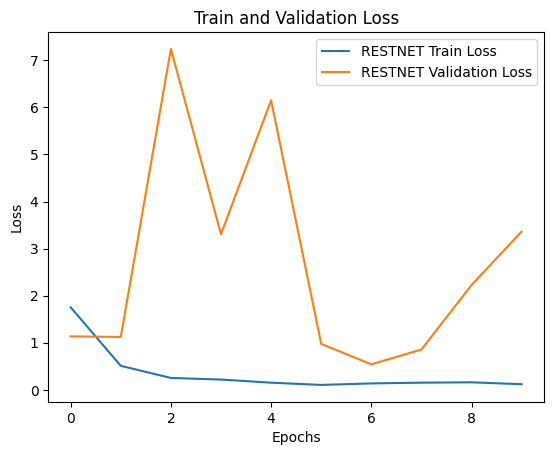

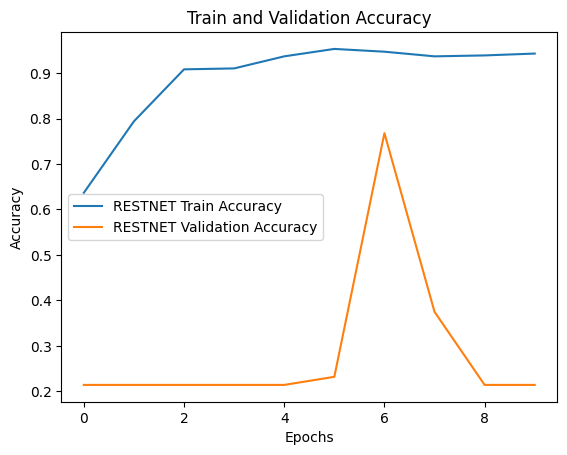

In [ ]:
plt.figure()
plt.plot(train_loss, label='RESTNET Train Loss')
plt.plot(val_loss , label='RESTNET Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot(train_accuracy, label='RESTNET Train Accuracy')
plt.plot(val_accuracy, label='RESTNET Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

### Predicting Test Image using VGG16 Model

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 666ms/step


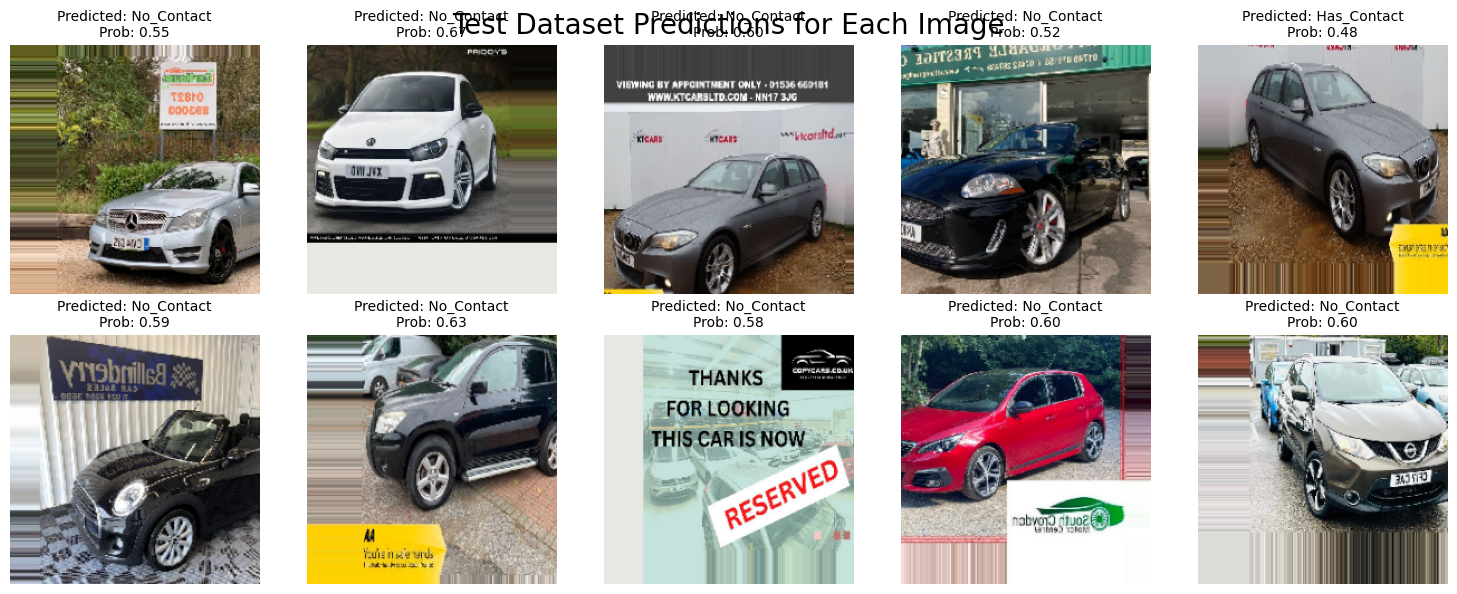

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Number of top predictions to display (since it's binary, we can show two)
top_n = 2

# Make predictions on the test data
test_predictions = vgg16_model.predict(test_generator, verbose=1)

# Get class labels from the test generator
class_indices = test_generator.class_indices
labels = list(class_indices.keys())  # Should be ['class_0', 'class_1']

# Get a batch of images from the test generator
images, _ = next(test_generator)

# Rescale the images if needed (e.g., if rescaled in generator)
images = images * 255.0  # Reverse normalization if applied in the generator

# Create a plot with 2 rows and 5 columns
num_images = len(images)
n_rows = 2
n_cols = 5
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 6))

# Adjust the number of images to be displayed based on batch size
idx = 0
for i in range(n_rows):  # Loop over rows
    for j in range(n_cols):  # Loop over columns
        if idx >= num_images:  # If there are no more images to plot
            ax[i, j].axis("off")  # Turn off the axis for unused subplots
            continue

        # Get the predicted probability for the positive class
        prob = test_predictions[idx][0]  # Only one output for binary classification
        pred_class = labels[1] if prob > 0.5 else labels[0]  # Assign class based on threshold

        # Create a title string with the prediction
        title = f"Predicted: {pred_class}\nProb: {prob:.2f}"

        # Plot the image and set the title
        ax[i, j].imshow(images[idx].astype("uint8"))  # Ensure the image is in uint8 for correct display
        ax[i, j].set_title(title, fontsize=10)
        ax[i, j].axis("off")  # Turn off the axis
        idx += 1

# Adjust layout and display the plot
plt.tight_layout()
plt.suptitle("Test Dataset Predictions for Each Image", fontsize=20)
plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 333ms/step


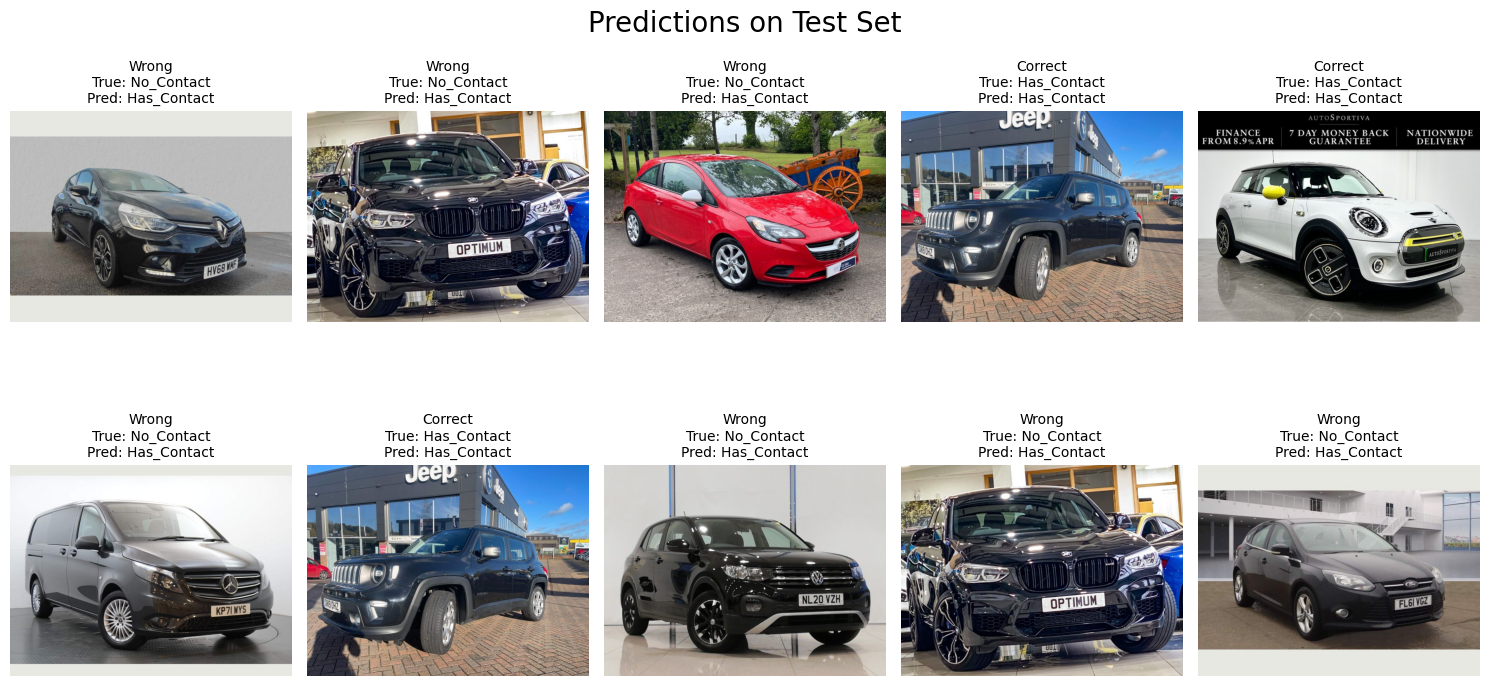

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Step 1: Generate predictions from the model and true labels from the test generator
y_true = test_generator.classes  # True labels from test generator
y_pred = vgg16_model.predict(test_generator)  # Model predictions

# Step 2: Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Step 3: Create a figure with subplots
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 8))
test_images = np.asarray(test_generator.filenames)  # Get test images' filenames

# Step 4: Loop over the subplots to show both correct and incorrect predictions
for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(y_true))  # Randomly pick an image index
        true_label = list(test_generator.class_indices.keys())[y_true[idx]]
        predicted_label = list(test_generator.class_indices.keys())[y_pred_classes[idx]]

        # Define if prediction is correct or wrong
        if y_true[idx] == y_pred_classes[idx]:
            title = f"Correct\nTrue: {true_label}\nPred: {predicted_label}"
        else:
            title = f"Wrong\nTrue: {true_label}\nPred: {predicted_label}"

        # Read and display the image
        img_path = os.path.join(test_generator.directory, test_images[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        ax[i, j].imshow(img)
        ax[i, j].set_title(title, fontsize=10)
        ax[i, j].axis("off")

# Step 5: Adjust layout and show
plt.tight_layout()
plt.suptitle('Predictions on Test Set', fontsize=20)
plt.show()


In [ ]:
# Evaluate the model on the test set
results = vgg16_model.evaluate(test_generator, batch_size=batch_size)

# Print all returned values to see what is being returned
print(f"Evaluation Results: {results}")

# If 'results' contains more values (e.g., other metrics), you can extract specific ones
test_loss = results[0]  # Assuming the first value is loss
test_accuracy = results[1]  # Assuming the second value is accuracy

print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step - accuracy: 0.7627 - loss: 0.5346
Evaluation Results: [0.48529917001724243, 0.7910447716712952]
Test Loss:     0.48529917001724243
Test Accuracy: 0.7910447716712952


### Confusion Matrix

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 400ms/step


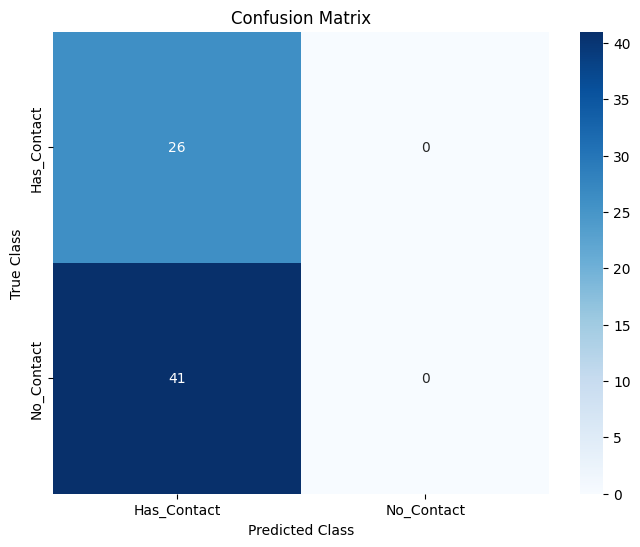

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import cv2
import os

# Step 1: Generate predictions from the model and true labels from the test generator
y_true = test_generator.classes  # True labels from test generator
y_pred = vgg16_model.predict(test_generator)  # Model predictions

# Step 2: Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Step 3: Calculate confusion matrix
cf_mtx = confusion_matrix(y_true, y_pred_classes)
labels = list(test_generator.class_indices.keys())

# Step 4: Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cf_mtx, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import pandas as pd

# Convert y_true and y_pred to integers if necessary
y_true = [int(label) for label in y_true]
y_pred = [int(label) for label in y_pred]

# List to store true vs predicted class names
true_vs_pred = []

# Assuming labels is a list of class names, for example: ['Class A', 'Class B']
for true_label, predicted_label in zip(y_true, y_pred):
    true_class = labels[true_label] if true_label < len(labels) else 'Unknown'
    pred_class = labels[predicted_label] if predicted_label < len(labels) else 'Unknown'
    true_vs_pred.append([true_class, pred_class])

# Create a DataFrame
df = pd.DataFrame(true_vs_pred, columns=['True Class', 'Predicted Class'])

# Display the DataFrame
print(df)


     True Class Predicted Class
0   Has_Contact     Has_Contact
1   Has_Contact     Has_Contact
2   Has_Contact     Has_Contact
3   Has_Contact     Has_Contact
4   Has_Contact     Has_Contact
..          ...             ...
62   No_Contact     Has_Contact
63   No_Contact     Has_Contact
64   No_Contact     Has_Contact
65   No_Contact     Has_Contact
66   No_Contact     Has_Contact

[67 rows x 2 columns]


In [ ]:
from sklearn.metrics import classification_report

# Assuming labels is a list, e.g., labels = ['Class A', 'Class B']
print(classification_report(y_true, y_pred, target_names=labels))


              precision    recall  f1-score   support

 Has_Contact       0.39      1.00      0.56        26
  No_Contact       0.00      0.00      0.00        41

    accuracy                           0.39        67
   macro avg       0.19      0.50      0.28        67
weighted avg       0.15      0.39      0.22        67



## Explainability with Gradient Activation Mapping (Grad-CAM)

In [ ]:
# Grad-CAM implementation
last_conv_layer = vgg16_model.get_layer('block5_conv3')  # For VGG16; adjust if using ResNet50
# last_conv_layer = model.get_layer('conv5_block3_out') # Use this if using
# ResNet50 %%

In [ ]:
# Create a model that maps the input image to the activations of the last conv layer and the output predictions
grad_model = Model([vgg16_model.inputs], [last_conv_layer.output, vgg16_model.output])

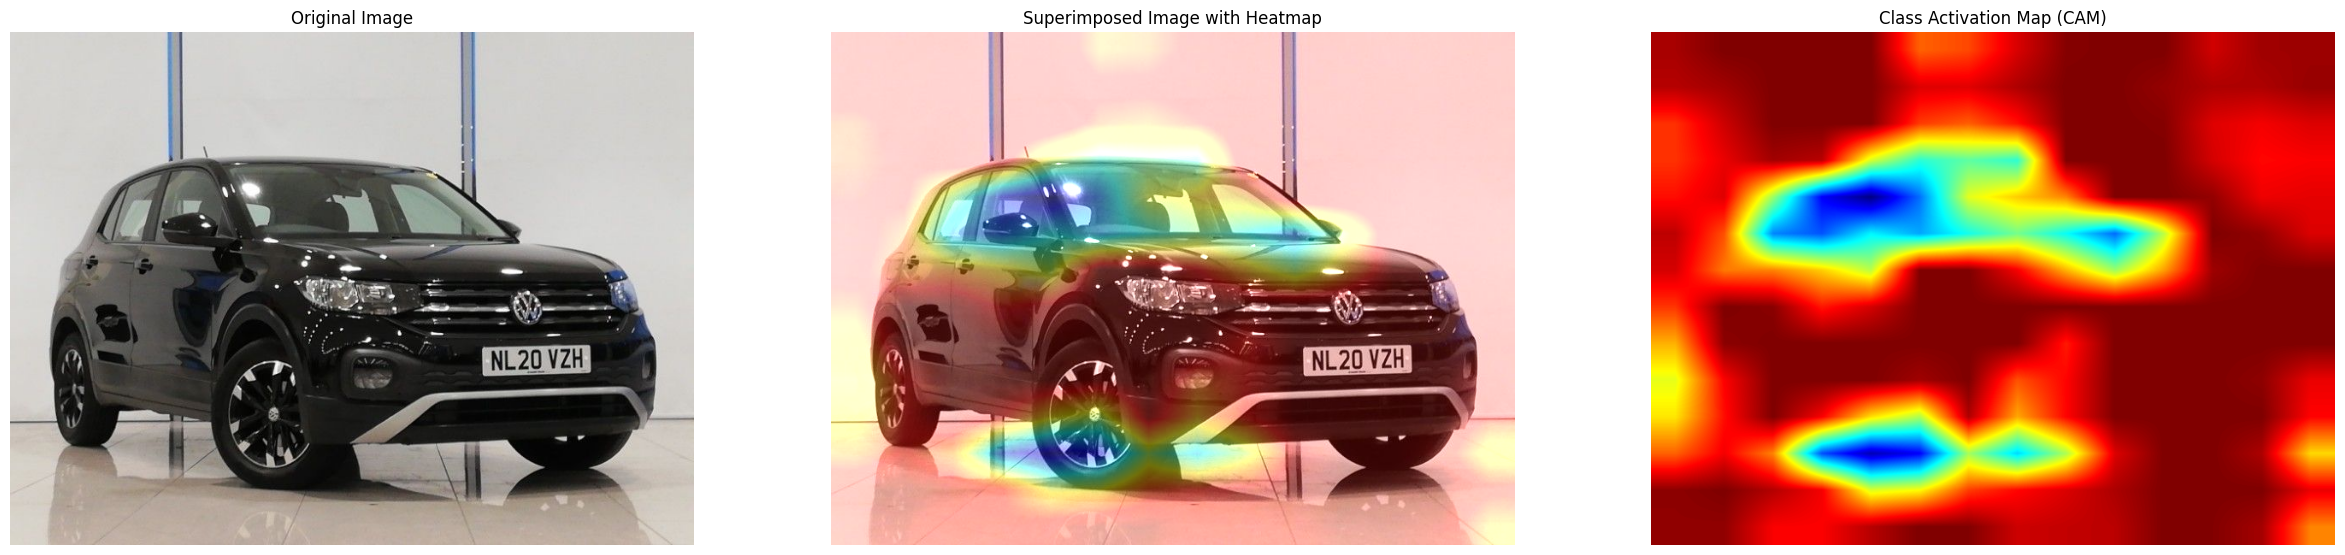

In [ ]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def grad_cam(grad_model, img_array, last_conv_layer_name, predicted_class):
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        tape.watch(conv_outputs)
        loss = predictions[:, predicted_class]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    conv_outputs *= pooled_grads.numpy()
    heatmap = tf.reduce_mean(conv_outputs, axis=-1).numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) > 0 else 1
    return heatmap

def preprocess_image(img_path, target_size=(224, 224)):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)

# Define paths and models
img_path = '/content/drive/MyDrive/Data/test/No_Contact/5dc58956cff54f80a86b189608fe5734.jpg'
last_conv_layer_name = 'block5_conv3'

# Load VGG16 model pre-trained on ImageNet data
vgg16_model = tf.keras.applications.VGG16(weights='imagenet')

# Create a grad model that outputs the last convolutional layer's activations and the final predictions
grad_model = tf.keras.Model(
    inputs=[vgg16_model.inputs],
    outputs=[vgg16_model.get_layer(last_conv_layer_name).output, vgg16_model.output]
)

# Preprocess the image and make predictions
img_array = preprocess_image(img_path)
predictions = grad_model(img_array)[1]
predicted_class = tf.argmax(predictions[0]).numpy()

# Generate the heatmap using Grad-CAM
heatmap = grad_cam(grad_model, img_array, last_conv_layer_name, predicted_class)

# Load and prepare the original image
original_img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

# Resize heatmap to match the original image size
heatmap_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))

# Convert heatmap to an 8-bit image
heatmap_resized = np.uint8(255 * heatmap_resized)

# Apply color mapping to the heatmap
heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

# Superimpose the heatmap on the original image
superimposed_img = np.clip(heatmap_resized * 0.4 + original_img, 0, 255).astype('uint8')

# Save the superimposed image
cv2.imwrite('grad_cam_output.jpg', superimposed_img)

# Plot the original image, superimposed image, and resized CAM plot (last)
plt.figure(figsize=(30, 10))

# Plot the original image
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(original_img)
plt.axis('off')

# Plot the superimposed image
plt.subplot(1, 3, 2)
plt.title('Superimposed Image with Heatmap')
plt.imshow(superimposed_img)
plt.axis('off')

# Plot the resized heatmap (CAM) in the last position
plt.subplot(1, 3, 3)
plt.title('Class Activation Map (CAM)')
plt.imshow(heatmap_resized, cmap='jet')
plt.axis('off')

plt.show()


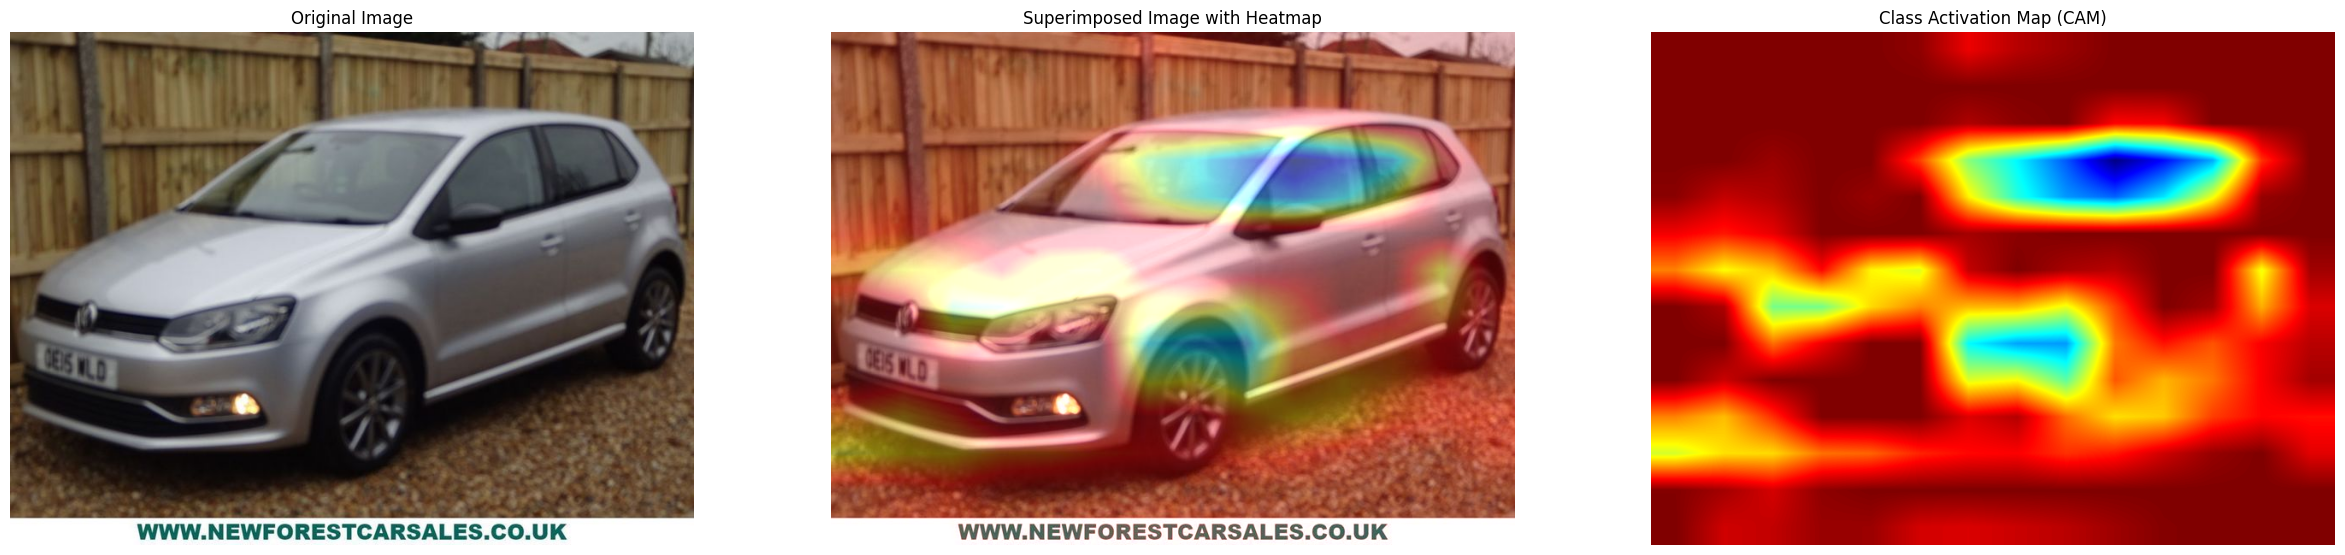

In [ ]:
def grad_cam(grad_model, img_array, last_conv_layer_name, predicted_class):
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        tape.watch(conv_outputs)
        loss = predictions[:, predicted_class]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    conv_outputs *= pooled_grads.numpy()
    heatmap = tf.reduce_mean(conv_outputs, axis=-1).numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) > 0 else 1
    return heatmap

def preprocess_image(img_path, target_size=(224, 224)):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)

# Define paths and models
img_path = '/content/drive/MyDrive/Data/test/No_Contact/5dc58956cff54f80a86b189608fe5734.jpg'
last_conv_layer_name = 'block5_conv3'

# Load VGG16 model pre-trained on ImageNet data
vgg16_model = tf.keras.applications.VGG16(weights='imagenet')

# Create a grad model that outputs the last convolutional layer's activations and the final predictions
grad_model = tf.keras.Model(
    inputs=[vgg16_model.inputs],
    outputs=[vgg16_model.get_layer(last_conv_layer_name).output, vgg16_model.output]
)

# Preprocess the image and make predictions
img_array = preprocess_image(img_path)
predictions = grad_model(img_array)[1]
predicted_class = tf.argmax(predictions[0]).numpy()

# Generate the heatmap using Grad-CAM
heatmap = grad_cam(grad_model, img_array, last_conv_layer_name, predicted_class)

# Load and prepare the original image
original_img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

# Resize heatmap to match the original image size
heatmap_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))

# Convert heatmap to an 8-bit image
heatmap_resized = np.uint8(255 * heatmap_resized)

# Apply color mapping to the heatmap
heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

# Superimpose the heatmap on the original image
superimposed_img = np.clip(heatmap_resized * 0.4 + original_img, 0, 255).astype('uint8')

# Save the superimposed image
cv2.imwrite('grad_cam_output.jpg', superimposed_img)

# Plot the original image, superimposed image, and resized CAM plot (last)
plt.figure(figsize=(30, 10))

# Plot the original image
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(original_img)
plt.axis('off')

# Plot the superimposed image
plt.subplot(1, 3, 2)
plt.title('Superimposed Image with Heatmap')
plt.imshow(superimposed_img)
plt.axis('off')

# Plot the resized heatmap (CAM) in the last position
plt.subplot(1, 3, 3)
plt.title('Class Activation Map (CAM)')
plt.imshow(heatmap_resized, cmap='jet')
plt.axis('off')

plt.show()


### Adding Custom Layer to the Output Layer

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tqdm.keras import TqdmCallback

# Define the VGG16 model for binary classification
def create_vgg16_model(input_shape):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Binary classification: 1 output with sigmoid activation
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    return model

# Define input shape (224x224x3)
width, height = 224, 224
input_shape = (width, height, 3)

# Create the VGG16 model for binary classification
vgg16_model = create_vgg16_model(input_shape)

# Compile the model for binary classification
vgg16_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=BinaryCrossentropy(),  # Use binary cross-entropy for binary classification
    metrics=['accuracy']
)

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
tqdm_progress_bar = TqdmCallback()

# Train the model
Model_Train = vgg16_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    verbose=0,  # Using custom tqdm callback for progress bar
    callbacks=[reduce_lr, early_stopping, tqdm_progress_bar]
)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 420ms/step


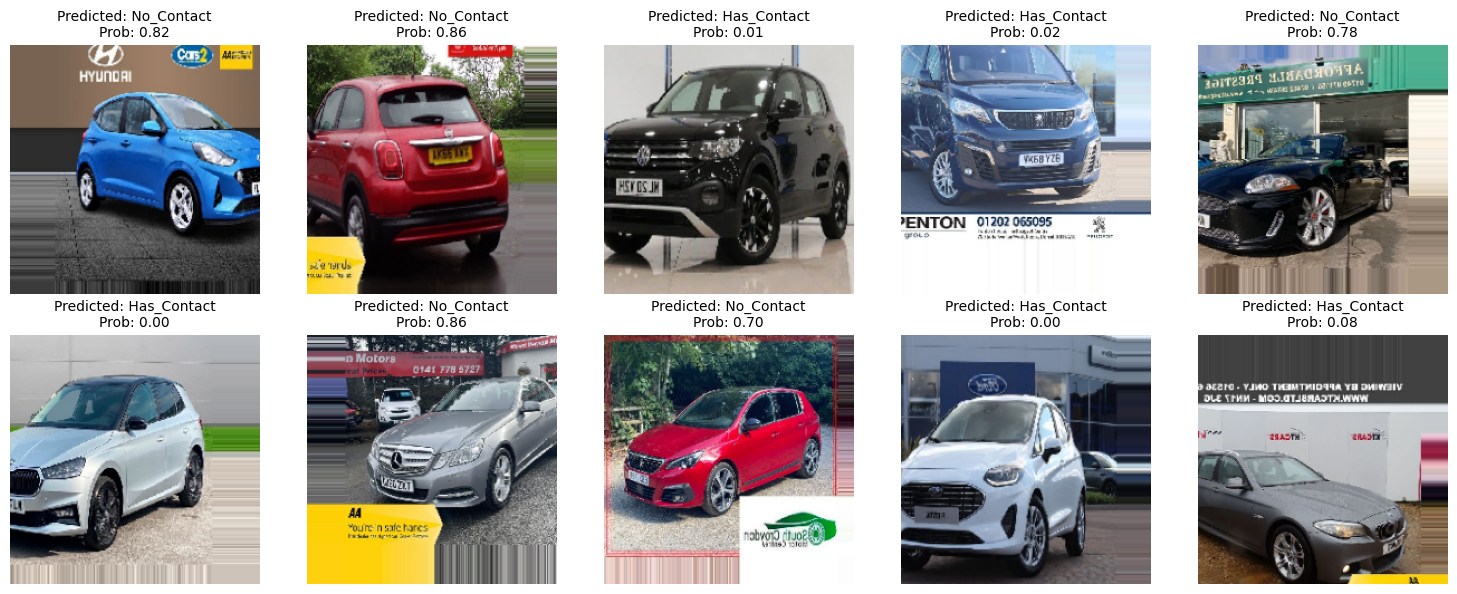

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Number of top predictions to display (since it's binary, we can show two)
top_n = 2

# Make predictions on the test data
test_predictions = vgg16_model.predict(test_generator, verbose=1)

# Get class labels from the test generator
class_indices = test_generator.class_indices
labels = list(class_indices.keys())  # Should be ['class_0', 'class_1']

# Get a batch of images from the test generator
images, _ = next(test_generator)

# Rescale the images if needed (e.g., if rescaled in generator)
images = images * 255.0  # Reverse normalization if applied in the generator

# Create a plot with 2 rows and 5 columns
num_images = len(images)
n_rows = 2
n_cols = 5
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 6))

# Adjust the number of images to be displayed based on batch size
idx = 0
for i in range(n_rows):  # Loop over rows
    for j in range(n_cols):  # Loop over columns
        if idx >= num_images:  # If there are no more images to plot
            ax[i, j].axis("off")  # Turn off the axis for unused subplots
            continue

        # Get the predicted probability for the positive class
        prob = test_predictions[idx][0]  # Only one output for binary classification
        pred_class = labels[1] if prob > 0.5 else labels[0]  # Assign class based on threshold

        # Create a title string with the prediction
        title = f"Predicted: {pred_class}\nProb: {prob:.2f}"

        # Plot the image and set the title
        ax[i, j].imshow(images[idx].astype("uint8"))  # Ensure the image is in uint8 for correct display
        ax[i, j].set_title(title, fontsize=10)
        ax[i, j].axis("off")  # Turn off the axis
        idx += 1

# Adjust layout and display the plot
plt.tight_layout()
plt.suptitle("Test Dataset Predictions for Each Image", fontsize=20)
plt.show()
